# Validating the binary implementation of LBMeX

1. [SRT](#Single-Relaxation-Time)
    1. [Coexistence curve](#Coexistence-curve)
    2. [Interface properties](#Interface-width-and-surface-tension)
2. [MRT](#Multiple-Relaxation-Time)
    1. [Coexistence curve](#Coexistence-curve)
    2. [Interface properties](#Interface-width-and-surface-tension)
        1. [Flat interfaces](#Flat-Interface)
        2. [Droplet](#Droplet)
        3. [Capillary Waves](#Capillary-Waves)
3. [Comparing SRT and MRT implementations](#Comparing-SRT-and-MRT-Implementations)
    1. [Flat interfaces](#Flat-Interfaces)
    2. [Droplets](#Droplets)
    3. [Discretization effects](#Discretization-effects)
4. [Fluctating LBMeX Implementation](#Fluctuating-LBMeX)


[Swift et al paper](https://journals.aps.org/pre/pdf/10.1103/PhysRevE.54.5041)

[Semprebon paper](https://journals.aps.org/pre/pdf/10.1103/PhysRevE.93.033305)

[Ulf repo](https://github.com/uschille/amrex-tutorials/tree/binary)

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yt
from yt.frontends.boxlib.data_structures import AMReXDataset
yt.set_log_level(50)
from matplotlib import animation
from IPython.display import HTML
import os
from subprocess import Popen, PIPE
# import mpi4py
import shlex
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
import glob
import pandas as pd

### Animation utilities

Below functions help to plot data as animations easily. For `cmap_ani`, the input data is a 3D array with the time series as the first dimension and the 2D array to plot as dimensions 2 and 3. In a schematic, it would look like this $(t, x, y)$ where t is the time series and x and y is the 2D data.

In [3]:
def cmap_ani(data, interval=50):
    def init():
        img.set_data(data[0])
        return (img,)

    def update(i):
        img.set_data(data[i])
        return (img,)

    fig, ax = plt.subplots()
    img = ax.imshow(data[0], cmap = 'bwr', vmin = np.amin(data), vmax = np.amax(data))
#     plt.imshow(rho, vmin = rho0-0.1, vmax = rho0+0.1, cmap = 'bwr')
    fig.colorbar(img, ax = ax, orientation="horizontal", pad=0.2)
    ani = animation.FuncAnimation(fig, update, frames=len(data), init_func=init, interval=interval, blit=True)
    plt.close()
    return ani

def plot_ani(x, y, interval = 50, titles = None):
    fig, ax = plt.subplots()
    ln, = ax.plot(x[0], y[0])
    ax.set(ylim = (np.amin(y), np.amax(y)), xlim = (np.amin(x), np.amax(x)))
    if type(titles) != None:
        title = ax.text(0.9,0.85, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5}, transform=ax.transAxes, ha="center")

    def init():
        if type(titles) != None:
            title.set_text(titles[0])
        ln.set_data(x[0], y[0])
        return ln,

    def update(i):
        if type(titles) != None:
            title.set_text(titles[i])
        ln.set_data(x[i], y[i])
        return ln,

    ani = animation.FuncAnimation(fig, update, frames= len(x), init_func=init, interval=interval, blit=True)
    plt.close()
    return ani

def yt_ani(ts, axis = "z"):
    plot = yt.SlicePlot(ts[0], axis, ("boxlib", "phi"))
    # plot.set_zlim(("gas", "density"), 8e-29, 3e-26)

    fig = plot.plots[("boxlib", "phi")].figure

    # animate must accept an integer frame number. We use the frame number
    # to identify which dataset in the time series we want to load
    def animate(i):
        ds = ts[i]
        plot._switch_ds(ds)


    ani = animation.FuncAnimation(fig, animate, frames=len(ts))
    plt.close()
    return ani

# Override matplotlib's defaults to get a nicer looking font
# with rc_context({"mathtext.fontset": "stix"}):
#     animation.save("animation.mp4")

### Calcualting interface width

The slope of the profile can be defined as $ m = \frac{dC}{dx}$ which can be rewritten in a more general sense as $ \Delta x = \frac{ \Delta C}{m}$. 

The gradient, $m$, can then be rewritten in the form, $\frac{dC}{dx}$. In this case, as we know that the interface will be at location $x = 0.5L$ where L is the box length, the interface width can then be expressed as, 

$$ d_{int}  = \frac{\Delta C}{\frac{dC}{dx}|_{x = L/2}}$$

Where $d_{int}$ is the interface width, $\Delta C = \phi_{max} - \phi_{min}$ where $\phi$ is the order parameter. $\frac{dC}{dx}|_{x = L/2}$ can be obtained using a function like `np.gradient`

In [4]:
def interface_width(phi, tol = 2*10**-1):
    phi_min = np.amin(phi)
    phi_max = np.amax(phi)
    max_grad = np.amax(np.abs(np.gradient(phi)))
    d = (phi_max - phi_min)/max_grad
    return d

### 1D profile, free energy and surface tension calculation 

The bulk free energy of the system, $\psi$ is, 

$$ \psi(\Delta n, n, T) = \frac{\lambda}{4}n(1 - (\frac{\Delta n}{n})^2 ) - Tn + \frac{T}{2}(n + \Delta n)ln(\frac{n + \Delta n}{2}) + \frac{T}{2}(n - \Delta n)ln(\frac{n + \Delta n}{2})$$

Where $\lambda$ is the strength of the interaction and $T$ is a temperature like parameter. $\Delta n$ is the density difference towards which the sytem phase separates. To obtain the chemical potential, the derivate of $\psi$ is taken with respect to $n$ to obtain, 

$$ \Delta \mu(\Delta n, n, T) = - \frac{\lambda \Delta n}{2 n} + \frac{T}{2} ln(\frac{1 + \frac{\Delta n}{n} }{1 - \frac{\Delta n}{n} }) - \kappa \nabla^2 (\Delta n)$$ 

In [5]:
import scipy
from scipy.optimize import fsolve
from scipy.integrate import solve_bvp

rho = 1

def coexistence(T=0.5, Lambda=1.1):
    phi0 = fsolve(lambda phi: -Lambda/2*phi/rho + T/2*np.log((rho+phi)/(rho-phi)), x0=0.5)
    return phi0[0]

def profile(kappa, T=0.5, Lambda=1.1, L = 64):

    def fun(x, y):
        phi, psi = y
        dphi = psi
        dpsi = - Lambda/(2*kappa)*phi/rho + T/(2*kappa)*np.log((rho+phi)/(rho-phi))
        return np.vstack([dphi, dpsi])

    def bc(ya, yb):
        return np.array([ya[0]+phi0,yb[0]-phi0]).reshape(2,)

    x = np.linspace(-L//2, L//2-1, L)+0.5
    phi0 = coexistence(T, Lambda)
    y0 = np.vstack([phi0*np.tanh(x), phi0*(1-np.tanh(x)**2)])

    res = solve_bvp(fun, bc, x, y0)
    
    return x, res.sol

def free_energy(rho, phi, kappa, T=0.5, Lambda=1.1):
    C1 = (rho+phi)/2
    C2 = (rho-phi)/2
    f = kappa/2*np.gradient(rho)**2 + kappa/2*np.gradient(phi)**2 \
        + Lambda/4*rho*(1-phi**2/rho**2) \
        - T*rho + T*C1*np.log(C1) + T*C2*np.log(C2)
    return f

def surface_tension(kappa, T=0.5, Lambda=1.1, L = 64):
    x, sol = profile(kappa, T, Lambda, L)
    phi = sol(x)[0]
    f = free_energy(np.full_like(x,1), phi, kappa, T, Lambda)
    sigma = (f-f[-1]).sum()
    return sigma

### Radius of a droplet

In [6]:
def droplet_radius(ds_yt):
    ad = ds_yt.all_data()
    
    center = ds_yt.r[0.5,0.5,0.5]
    corner = ds_yt.r[0.0,0.0,0.0]
    
    rho_d = 0.5*(center['rho']+center['phi'])[0].value
    rho_s = 0.5*(corner['rho']+corner['phi'])[0].value
    
    M = (0.5*(ad['rho']+ad['phi'])-rho_s).sum().value
    r = np.cbrt(3/4/np.pi*M/(rho_d-rho_s))
    return r

## Helper functions

In [7]:
def directory_to_df(k_flat):
    d = {'Directory':[], 'k':[], 'T':[], 'R':[]}

    for i in k_flat:
        T_flat = sorted(glob.glob(i + '/T*'))
        kappa = float(i.split('/')[-1].split('_')[-1])
        # print(k)
        for j in T_flat:
            R_flat = sorted(glob.glob(j + '/R*'))
            # print(R_flat)
            T = float(j.split('/')[-1].split('_')[-1])
            if len(R_flat) == 0:
                d['Directory'].append(j)
                d['k'].append(kappa)
                d['T'].append(T)
                d['R'].append(np.NaN)
            else:
                for k in R_flat:
                    R = float(k.split('/')[-1].split('_')[-1])
                    d['Directory'].append(k)
                    d['k'].append(kappa)
                    d['T'].append(T)
                    d['R'].append(R)
    df_flat = pd.DataFrame(d)
    return df_flat

def get_params(df_flat):
    directories = df_flat['Directory'].to_numpy()
    n = directories.size
    profile_sim = []
    sigma_sim = []
    profile_theory = []
    sigma_theory = []
    R_ls = []
    P_ls = []
    width_sim = []
    width_theory = []

    for i in range(n):
        curr_row = df_flat.iloc[i]

        k = curr_row['k']
        T = curr_row['T']
        R = curr_row['R']
        
        try:
            ts = yt.load(curr_row['Directory'] + '/plt*')
        except FileNotFoundError:
            profile_sim.append(np.NaN)
            sigma_sim.append(np.NaN)
            sigma_theory.append(np.NaN)
            profile_theory.append(np.NaN)
            width_sim.append(np.NaN)
            width_theory.append(np.NaN)
            R_ls.append(np.NaN)
            P_ls.append(np.NaN)
            continue
        
        ds = ts[-1]

        if np.isnan(R):
            phi = ds.r[:, 0.5, 0.5]['phi']
            phi = np.flip(phi)
            profile_sim.append(phi)
    
            f = free_energy(np.ones(phi[5:-4].size), phi[5:-4], k, T)
            sigma = (f-f[-1]).sum()
            sigma_sim.append(sigma)
            # print(k, T,  phi[5:-4].size)
            sigma_theory.append(surface_tension(kappa = k, T = T, L = phi[5:-4].size))
            x, sol = profile(kappa = k, T = T, L = phi.size)
            profile_theory.append(sol(x)[0])
            
            width_sim.append( interface_width(phi[5:-4]) )
            width_theory.append(interface_width(sol(x)[0]))
            
            R_ls.append(np.NaN)
            P_ls.append(np.NaN)
        else:
            phi = ds.r[0.5, 0.5, :]['phi']
            profile_sim.append(phi)
            
            R = droplet_radius(ds)
            dp = ds.r[0.5, 0.5, 0.5]['p_bulk'] - ds.r[0, 0, 0]['p_bulk']            
            R_ls.append(R)
            P_ls.append(float(dp[0]))
            
            f = free_energy(np.ones(phi[5:phi.size//2].size), phi[5:phi.size//2], k, T)
            sigma = (f-f[-1]).sum()
            sigma_sim.append(sigma)
            
            sigma_theory.append(surface_tension(kappa = k, T = T, L = phi.size//2))
            x, sol = profile(kappa = k, T = T, L = phi.size//2)
            profile_theory.append(sol(x)[0])
            
            width_sim.append( interface_width(phi[5:phi.size//2 + 1]) )
            width_theory.append(interface_width(sol(x)[0]))
    
    df_flat['$\sigma$_sim'] = sigma_sim
    df_flat['profile_sim'] = profile_sim
    df_flat['profile_theory'] = profile_theory
    df_flat['$\sigma$_theory'] = sigma_theory
    df_flat['radius'] = R_ls
    df_flat['pressure'] = P_ls
    df_flat['width_sim'] = width_sim
    df_flat['width_theory'] = width_theory
    
    return df_flat

def compare_kappa(df, element = 'sigma'):
    fig, axs = plt.subplots(1, 1, figsize = (7, 7))
    
    axs.plot(df['k'], df[element + '_theory'], '-rx', label = 'Theory')
    axs.plot(df['k'], df[element + '_sim'], '-bo', label = 'Simulation')
    axs.set(xlabel = r'$\kappa$', ylabel = element, title = element + ' vs $\kappa$')
    axs.legend()
    return fig

def compare_profile(df):
    (x, y) = df.shape
    fig, axs = plt.subplots(1, x, figsize = (15, 15//x))

    for i in range(x):
        axs[i].plot(df['profile_theory'].iloc[i], label = 'Theory')
        axs[i].plot(df['profile_sim'].iloc[i], label = 'Simulation')
        axs[i].set(xlabel = r'Box length', ylabel = r'$\phi$', title = '$\phi$ profile at $\kappa$ = ' + str(df['k'].iloc[i]))
        axs[i].legend()
    fig.tight_layout()
    return fig

def droplet_sigma_fit(df_drop):
    k_s = np.unique(df_drop['k'].to_numpy())
    T_s = np.unique(df_drop['T'].to_numpy())
    
    ls = []

    for i, k in enumerate(k_s):
        k_df = df_drop[df_drop['k'] == k]
        for j, T in enumerate(T_s):
            T_df = k_df[k_df['T'] == T]
            (x, y) = T_df.shape
            
            sigma = np.zeros(x)

            radii = T_df['radius'].to_numpy()
            pressure = T_df['pressure'].to_numpy()

            m, c = np.polyfit(1/(2*radii), pressure, deg = 1)
            sigma[:] = m
            
            T_df['$\sigma$_sim'] = sigma
            ls.append(T_df)

    concat_df = pd.concat(ls)
    return concat_df

## Test bed

In [8]:
# import h5py
# import numpy as np

# with h5py.File('plt00000.h5', "r") as f:
#     # print("Keys: %s" % f.keys())
#     a_group_keys = list(f.keys())
#     print(a_group_keys)
#     # # print(a_group_key)
#     # data = f[a_group_key]
#     data = f[a_group_keys[1]]
#     test = list(data.keys())
#     print(test)
#     ls_all_data = [data[i][()] for i in test]
#     # test_l1 = data[test[2]][()]
#     # print(test_l1.size)

# # dir(data)
# # data.keys()
# # list(data)

# reshape_test = test_l1.reshape(32, 32, 32, 6)

# plt.imshow(reshape_test[:, :, 32//2, 1])
# ls_all_data, test

# ts = yt.load('/home/nikhil/Documents/LBMeX/amrex-tutorials/GuidedTutorials/LBM/binary/surface_tension/T_0.450/R_0.200/plt*')
# ds = ts[-1]
# ad = ds.all_data()
# ds_slice = ds.r[:, 0.5, 0.5]
# yt.SlicePlot(ds, 'z', ['rho'])

# slice_z = ds.r[0.5, 0.5, :]['phi']
# slice_z
# dir(ds)
# test_obj = ds.slice('z', 0.5)
# pt = ds.r[(10.0, "km"), (200, "m"), (1.0, "km")]
# yt.ProfilePlot(test_obj, ('phi'), ('phi'))
# yt.LinePlot(ds, ['phi'], (0, 0, 0), (0, 0, 1), 64)

In [8]:
analysis_dir = '/home/nikhil/Documents/LBMeX/amrex-tutorials/GuidedTutorials/LBM/binary/surface_tension_analysis'

# Single Relaxation Time

In [9]:
top_dir = r'/home/nikhil/Documents/LBMeX/amrex-tutorials/GuidedTutorials/LBM/binary/interface_width'

k_SRT_flat = sorted(glob.glob(top_dir + '/k*'))
# k_SRT_flat
df_SRT_flat = directory_to_df(k_SRT_flat)
df_SRT_flat = get_params(df_SRT_flat)

/tmp/ipykernel_4475/4231528699.py:8: RuntimeWarning: invalid value encountered in log
  phi0 = fsolve(lambda phi: -Lambda/2*phi/rho + T/2*np.log((rho+phi)/(rho-phi)), x0=0.5)
/home/nikhil/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/tmp/ipykernel_4475/4231528699.py:16: RuntimeWarning: invalid value encountered in log
  dpsi = - Lambda/(2*kappa)*phi/rho + T/(2*kappa)*np.log((rho+phi)/(rho-phi))


## Coexistence curve

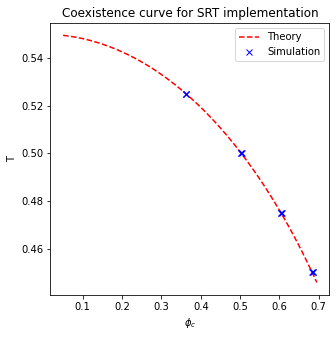

In [10]:
dn_s = np.arange(0.05, 0.7, 0.005)
T_theory = 1.1*dn_s/(np.log((1 + dn_s)/(1 - dn_s)))

profiles = df_SRT_flat['profile_sim'].to_numpy()
T_s = df_SRT_flat['T'].to_numpy()

for i, p in enumerate(profiles):
    profiles[i] = np.amax(p)


fig, axs = plt.subplots(1, 1, figsize = (5, 5))

axs.plot(dn_s, T_theory, '--r', label = 'Theory')
axs.plot(profiles, T_s, 'bx', label = 'Simulation')
axs.set(xlabel = r'$\phi_{c}$', ylabel = 'T', title = 'Coexistence curve for SRT implementation')
axs.legend()

fig.savefig(analysis_dir + '/SRT_flat_coexistence.png')

## Interface width and surface tension

In [11]:
T = 0.5
T_SRT_05 = df_SRT_flat[df_SRT_flat['T'] == T]

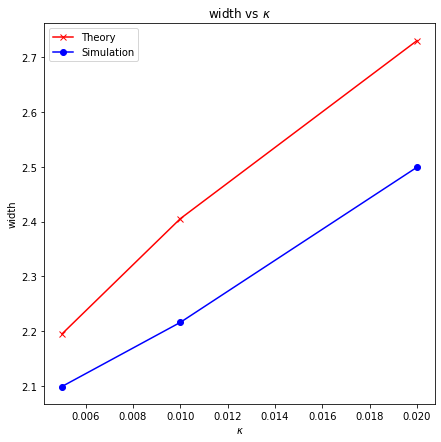

In [12]:
fig = compare_kappa(T_SRT_05, 'width')
fig.savefig(analysis_dir + '/SRT_flat_kappa_width_compare.png')

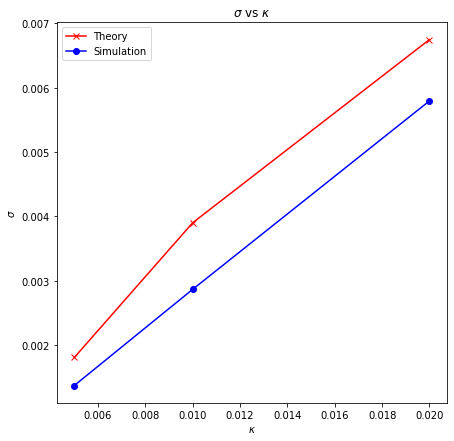

In [13]:
fig = compare_kappa(T_SRT_05, r'$\sigma$')
fig.savefig(analysis_dir + '/SRT_flat_sigma_compare.png')

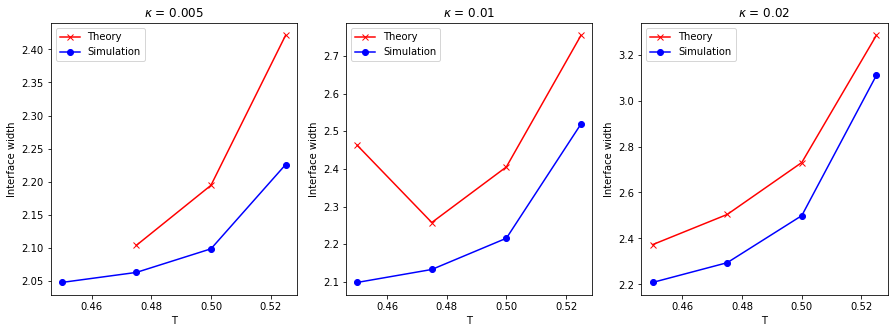

In [14]:
k_s = np.unique(df_SRT_flat['k'].to_numpy())

fig, axs = plt.subplots(1, k_s.size, figsize = (15, 15//k_s.size))

for i, k in enumerate(k_s):
    K_SRT = df_SRT_flat[df_SRT_flat['k'] == k]
    axs[i].plot(K_SRT['T'], K_SRT['width_theory'], '-rx', label = 'Theory')
    axs[i].plot(K_SRT['T'], K_SRT['width_sim'], '-bo', label = 'Simulation')
    axs[i].set(xlabel = 'T', ylabel = 'Interface width', title = r'$\kappa$ = ' + str(k))
    axs[i].legend()
fig.savefig(analysis_dir + '/SRT_flat_temp_width_compare.png')

# Multiple Relaxation Time

In [15]:
top_dir = r'/home/nikhil/Documents/LBMeX/amrex-tutorials/GuidedTutorials/LBM/binary/MRT_interface_width'

flat_interface_dir = top_dir + '/flat_interface'
k_MRT_flat = sorted(glob.glob(flat_interface_dir + '/k*'))
df_MRT_flat = directory_to_df(k_MRT_flat)
df_MRT_flat = get_params(df_MRT_flat)


droplet_dir = top_dir + '/droplet'
k_MRT_drop = sorted(glob.glob(droplet_dir + '/k*'))
df_MRT_drop = directory_to_df(k_MRT_drop)
df_MRT_drop = get_params(df_MRT_drop)

/tmp/ipykernel_4475/4231528699.py:8: RuntimeWarning: invalid value encountered in log
  phi0 = fsolve(lambda phi: -Lambda/2*phi/rho + T/2*np.log((rho+phi)/(rho-phi)), x0=0.5)
/home/nikhil/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/tmp/ipykernel_4475/4231528699.py:16: RuntimeWarning: invalid value encountered in log
  dpsi = - Lambda/(2*kappa)*phi/rho + T/(2*kappa)*np.log((rho+phi)/(rho-phi))


In [16]:
df_MRT_drop = droplet_sigma_fit(df_MRT_drop)
# df_MRT_drop

## Coexistence curve

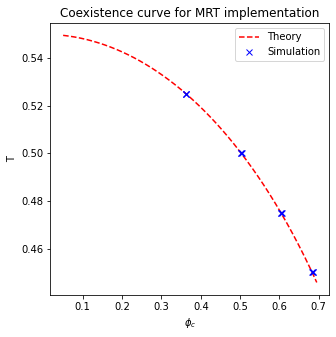

In [17]:
dn_s = np.arange(0.05, 0.7, 0.005)
T_theory = 1.1*dn_s/(np.log((1 + dn_s)/(1 - dn_s)))

profiles = df_MRT_flat['profile_sim'].to_numpy()
T_s = df_MRT_flat['T'].to_numpy()

for i, p in enumerate(profiles):
    profiles[i] = np.amax(p)

fig, axs = plt.subplots(1, 1, figsize = (5, 5))

axs.plot(dn_s, T_theory, '--r', label = 'Theory')
axs.plot(profiles, T_s, 'bx', label = 'Simulation')
axs.set(xlabel = r'$\phi_{c}$', ylabel = 'T', title = 'Coexistence curve for MRT implementation')
axs.legend()
fig.savefig(analysis_dir + 'MRT_coexistence.png')

## Interface width and surface tension

### Flat Interface

In [18]:
T = 0.5
T_MRT_05 = df_MRT_flat[df_MRT_flat['T'] == T]

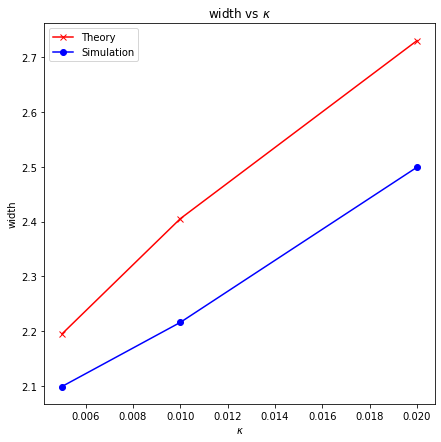

In [19]:
fig = compare_kappa(T_MRT_05, 'width')
fig.savefig(analysis_dir + 'MRT_flat_kappa_width_compare.png')

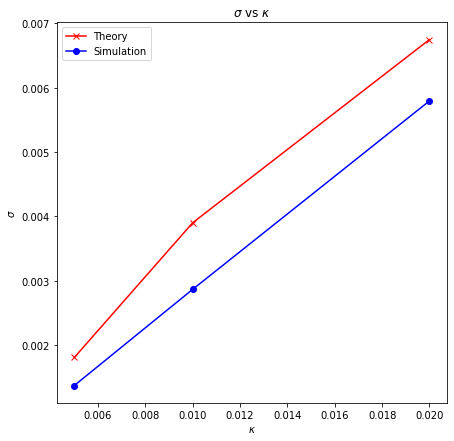

In [20]:
fig = compare_kappa(T_MRT_05, r'$\sigma$')
fig.savefig(analysis_dir + 'MRT_flat_sigma_compare.png')

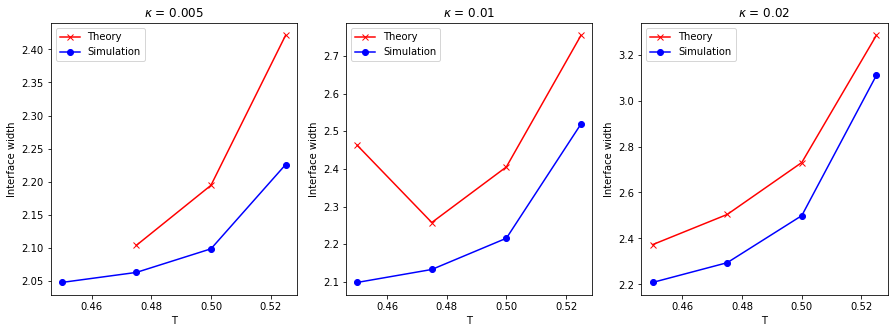

In [21]:
k_s = np.unique(df_MRT_flat['k'].to_numpy())

fig, axs = plt.subplots(1, k_s.size, figsize = (15, 15//k_s.size))

for i, k in enumerate(k_s):
    K_MRT = df_MRT_flat[df_MRT_flat['k'] == k]
    axs[i].plot(K_MRT['T'], K_MRT['width_theory'], '-rx', label = 'Theory')
    axs[i].plot(K_MRT['T'], K_MRT['width_sim'], '-bo', label = 'Simulation')
    axs[i].set(xlabel = 'T', ylabel = 'Interface width', title = r'$\kappa$ = ' + str(k))
    axs[i].legend()
fig.savefig(analysis_dir + '/MRT_flat_temp_width_compare.png')

### Droplet

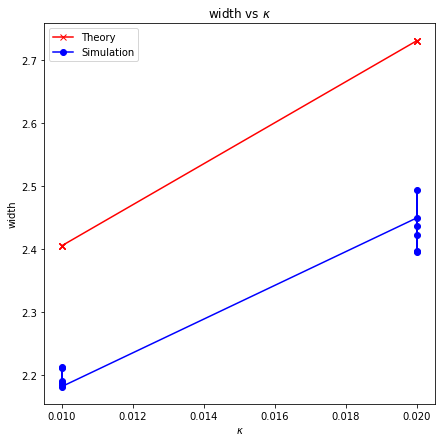

In [22]:
fig = compare_kappa(df_MRT_drop, r'width')
fig.savefig(analysis_dir + '/MRT_droplet_width_compare.png')

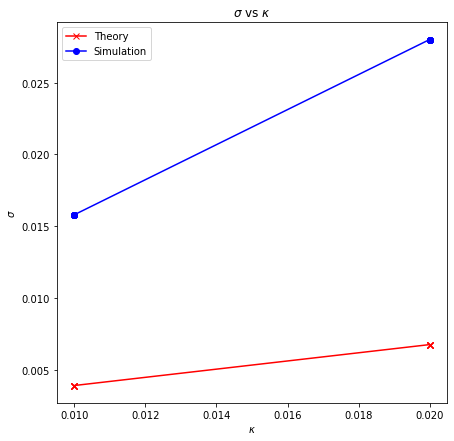

In [23]:
fig = compare_kappa(df_MRT_drop, r'$\sigma$')
fig.savefig(analysis_dir + '/MRT_droplet_sigma_compare.png')

In [24]:
# df_MRT_drop

In [25]:
# write = True

# row = df_MRT_drop.iloc[0]

# ts = yt.load(row['Directory'] + '/plt*')

# ani = yt_ani(ts, axis = 'x')

# if write == True:
#     writergif = animation.PillowWriter(fps=5) 
#     ani.save(analysis_dir + '/k_{}-T_{}-R_{}.gif'.format(row['k'], row['T'], row['R']), writer=writergif)
# HTML(ani.to_jshtml())

### Capillary Waves

#### Analysis Technique

[Stokes Dream](http://sites.apam.columbia.edu/courses/apph4200x/Behroozi_StokesDream_2010.pdf)

$$ a = a_{0}e^{-\alpha t}$$

$$ \alpha =  \frac{2k^2 \mu}{\rho v_g}$$

$$ v_g = \frac{g + \frac{3 \sigma k^2}{\rho} }{ 2 \sqrt{kg + \frac{\sigma k^3}{\rho} } } $$

$$ \mu = \frac{ (\frac{\alpha \rho}{2k^2}) (g + \frac{3 \sigma k^2}{\rho}) }{2 \sqrt{kg + \frac{\sigma k^3}{\rho} }} $$

$$ \omega^2 = kg + (\frac{ \sigma_{eff} }{\rho })k^3 $$

$$ \sigma_{eff} = \sigma - \sqrt{\frac{8 \mu^3 \omega}{\rho} } + \frac{4 k \mu^2}{\rho} $$

In [26]:
def find_crit_points(l, L):
    peaks = np.zeros(l, dtype = int)
    valleys = np.zeros(l, dtype = int)
    for i in range(l):
        peaks[i] = np.ceil((1/2 + 2*i)*(L -1)/(2*l))
        valleys[i] = np.ceil((3/2 + 2*i)*(L -1)/(2*l))
    return np.concatenate([peaks, valleys])

def get_slice_phi(ds, A = 0.2, axis = 'z', l = 2, L = 128):
    g = np.arange(0.5 - A, 0.5 + A, 1/L)
    phi_s = np.zeros((g.size, L))

    for i, slc in enumerate(g):
        if axis == 'z':
            phi_s[i] = ds.r[:, slc, slc]['phi']
        elif axis == 'y':
            phi_s[i] = ds.r[slc, :, slc]['phi']
        elif axis == 'x':
            phi_s[i] = ds.r[slc, slc, :]['phi']

    phi_s = np.flip(phi_s, axis = 0)
    
    return phi_s

def wave_amplitude(ts, A, l, L):

    peaks_n_valleys = find_crit_points(l, L)

    peak_idx = np.zeros((len(ts), peaks_n_valleys.size))

    for i, ds in enumerate(ts):
        phi_s = get_slice_phi(ds, A = A, l = l, L = L)
        for j in range(peaks_n_valleys.size):
            test = np.gradient(phi_s[:, peaks_n_valleys[j]])
            indexes = np.where(test > 0.2)
            # print(indexes)
            peak_idx[i, j] = indexes[0][0]

    for i in range(l*2):
        peak_idx[:, i] = peak_idx[:, i] - int(A/2*L)
        peak_idx[:, i] = peak_idx[:, i] - peak_idx[-1, i]

    return peak_idx

In [ ]:
path_gpu = '/home/nikhil/Documents/LBMeX/amrex-tutorials/GuidedTutorials/LBM/binary/capillary_waves/cpu_gpu_test/gpu'
path_cpu = '/home/nikhil/Documents/LBMeX/amrex-tutorials/GuidedTutorials/LBM/binary/capillary_waves/cpu_gpu_test/cpu'

write = True
ts_gpu = yt.load(path_gpu + '/plt*')
ts_cpu = yt.load(path_cpu + '/plt*')

ani_gpu = yt_ani(ts_gpu, axis = 'z')
ani_cpu = yt_ani(ts_cpu, axis = 'z')

if write == True:
    writergif = animation.PillowWriter(fps=5) 
    ani_gpu.save(path_gpu + '/gpu_waves.gif', writer=writergif)
    ani_cpu.save(path_cpu + '/cpu_waves.gif', writer=writergif)

In [ ]:
# HTML(ani.to_jshtml())

In [27]:
top_dir = r'/home/nikhil/Documents/LBMeX/amrex-tutorials/GuidedTutorials/LBM/binary/MRT_interface_width'
capillary_waves_dir = top_dir + '/capillary_waves'
k_MRT_waves = sorted(glob.glob(capillary_waves_dir + '/k*'))
df_MRT_waves = directory_to_df(k_MRT_waves)

df_MRT_waves

,Directory,k,T,R
0,/home/nikhil/Documents/LBMeX/amrex-tutorials/G...,0.010,0.5,NaN
1,/home/nikhil/Documents/LBMeX/amrex-tutorials/G...,0.015,0.5,NaN
2,/home/nikhil/Documents/LBMeX/amrex-tutorials/G...,0.020,0.5,NaN


In [32]:
# (x, y) = df_MRT_waves.shape

# l = 2
# L = 128
# A = 0.2

# for i in range(x):
#     row = df_MRT_waves.iloc[i]
#     ts = yt.load(row['Directory'] + '/plt*')
#     peak_idx = wave_amplitude(ts, A, l, L)
    

# write = False

row = df_MRT_waves.iloc[-1]

ts = yt.load(row['Directory'] + '/plt*')

ani = yt_ani(ts, axis = 'z')

# if write == True:
#     writergif = animation.PillowWriter(fps=5) 
#     ani.save(analysis_dir + '/k_{}-T_{}-R_{}-waves.gif'.format(row['k'], row['T'], row['R']), writer=writergif)
HTML(ani.to_jshtml())

In [29]:
l = 2
L = 128
A = 0.2
# ds = ts[0]
peak_idx = wave_amplitude(ts, A, l, L)

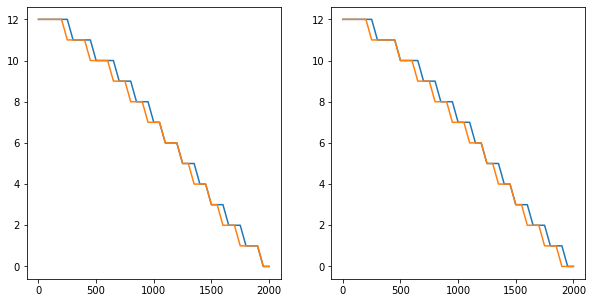

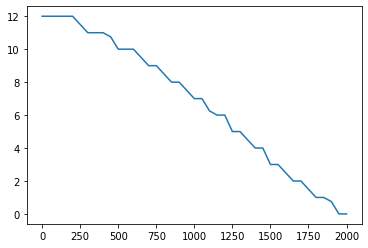

In [30]:
x = np.linspace(0, 2000, 41)
A = 0.2
fig, axs = plt.subplots(1, l, figsize = (5*l, 5))

A_s = np.zeros_like(x)

for i in range(l*2):
    # A_s += np.abs(peak_idx[:, i])
    plotly = np.abs(peak_idx[:, i])# - peak_idx[-1, i])
    axs[i%l].plot(x, plotly)
    A_s += plotly

A_s /= l*2

plt.figure(2)
plt.plot(x, A_s)

array([15.12838779, 10.09758636])

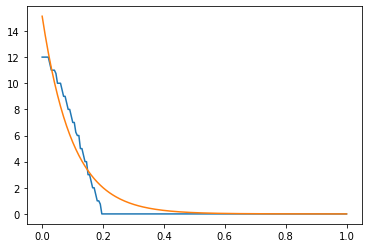

In [31]:
from scipy.optimize import curve_fit

def function(x, a, b):
    return a * np.exp(-b * x)

sz = 200

test = np.zeros(sz)

test[0:A_s.size] = A_s

# x = np.arange(0, sz*50, 50)
x = np.linspace(0, 1, sz)

popt, pcov = curve_fit(function, x, test)
# popt, pcov

plt.plot(x, test, label = 'Real')
plt.plot(x, function(x, *popt), label = 'Predicted')
popt

# Comparing SRT and MRT Implementations

## Flat Interfaces

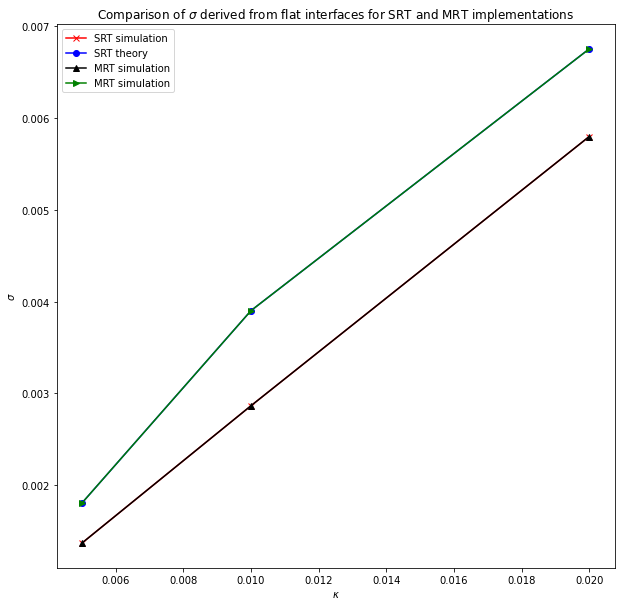

In [26]:
T_MRT_05 = df_MRT_flat[df_MRT_flat['T'] == 0.5]
T_SRT_05 = df_SRT_flat[df_SRT_flat['T'] == 0.5]

fig, axs = plt.subplots(1, 1, figsize = (10, 10))

compare = r'$\sigma$'

axs.plot(T_SRT_05['k'], T_SRT_05[compare + '_sim'],'-rx', label = 'SRT simulation')
axs.plot(T_SRT_05['k'], T_SRT_05[compare + '_theory'], '-bo', label = 'SRT theory')

axs.plot(T_MRT_05['k'], T_MRT_05[compare + '_sim'], '-k^', label = 'MRT simulation')
axs.plot(T_MRT_05['k'], T_MRT_05[compare + '_theory'], '-g>', label = 'MRT simulation')
axs.set(xlabel = r'$\kappa$', ylabel = r'$\sigma$', title = 'Comparison of $\sigma$ derived from flat interfaces for SRT and MRT implementations')
axs.legend()

fig.savefig(analysis_dir + '/SRT_vs_MRT_flat_sigma_compare.png')

## Droplets

## Discretization effects

In [27]:
top_dir = '/home/nikhil/Documents/LBMeX/amrex-tutorials/GuidedTutorials/LBM/binary/finite_difference/k_0.01/T_0.500'
all_nx = sorted(glob.glob(top_dir + '/nx*'))
k_s = [float(i.split('/')[-3].split('_')[-1]) for i in all_nx]
T_s = [float(i.split('/')[-2].split('_')[-1]) for i in all_nx]
nx_s = [float(i.split('/')[-1].split('_')[-1]) for i in all_nx]
R_s = [np.NaN for i in all_nx]
d = {'Directory':all_nx, 'k':k_s, 'T':T_s, 'R':R_s, 'nx':nx_s}
df_MRT_discrete = pd.DataFrame(d)

df_MRT_discrete = get_params(df_MRT_discrete)

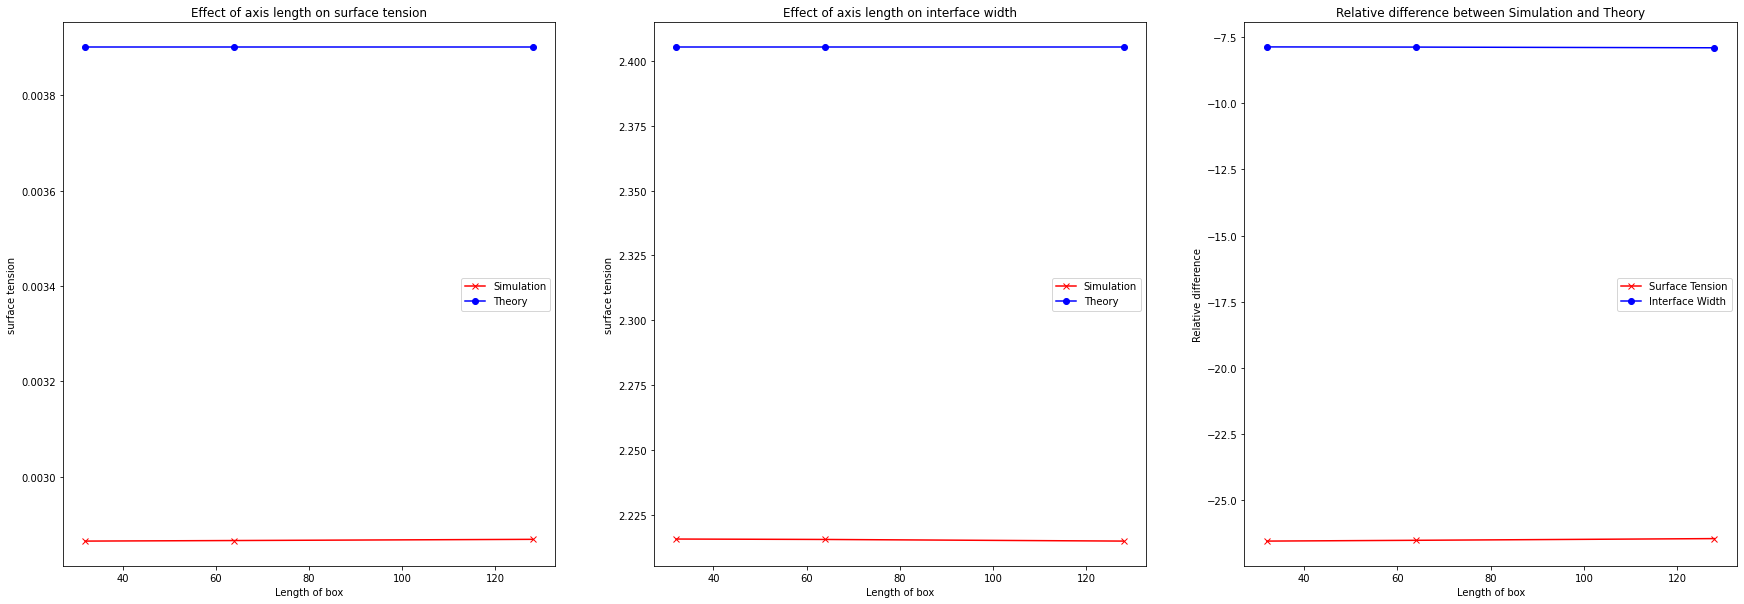

In [28]:
fig, axs = plt.subplots(1, 3, figsize = (30, 10))

nx = df_MRT_discrete['nx'].to_numpy()
idx = np.argsort(nx)
nx = nx[idx]

sigma_sim = df_MRT_discrete['$\sigma$_sim'].to_numpy()[idx]
sigma_theory = df_MRT_discrete['$\sigma$_theory'].to_numpy()[idx]

width_sim = df_MRT_discrete['width_sim'].to_numpy()[idx]
width_theory = df_MRT_discrete['width_theory'].to_numpy()[idx] 

# sigma
axs[0].plot(nx, sigma_sim, '-xr', label = 'Simulation')
axs[0].plot(nx, sigma_theory, '-ob', label = 'Theory')
axs[0].set(xlabel = 'Length of box', ylabel = 'surface tension', title = 'Effect of axis length on surface tension')
axs[0].legend()

axs[1].plot(nx, width_sim, '-xr', label = 'Simulation')
axs[1].plot(nx, width_theory, '-ob', label = 'Theory')
axs[1].set(xlabel = 'Length of box', ylabel = 'surface tension', title = 'Effect of axis length on interface width')
axs[1].legend()

axs[2].plot(nx, (sigma_sim - sigma_theory)*100/sigma_theory, '-xr', label = 'Surface Tension')
axs[2].plot(nx, (width_sim - width_theory)*100/width_theory, '-ob', label = 'Interface Width')
axs[2].set(xlabel = 'Length of box', ylabel = 'Relative difference', title = 'Relative difference between Simulation and Theory')
axs[2].legend()

fig.savefig(analysis_dir + '/discretization.png')

# Fluctuating LBMeX

In [50]:
top_dir = '/home/nikhil/Documents/LBMeX/amrex-tutorials/GuidedTutorials/LBM/binary/FHD_LB/naive/'
k_fluct_flat = sorted(glob.glob(top_dir + '/k*'))
# k_fluct_flat
df_fluct_flat = directory_to_df(k_fluct_flat)
df_fluct_flat

,Directory,k,T,R
0,/home/nikhil/Documents/LBMeX/amrex-tutorials/G...,0.01,0.5,NaN



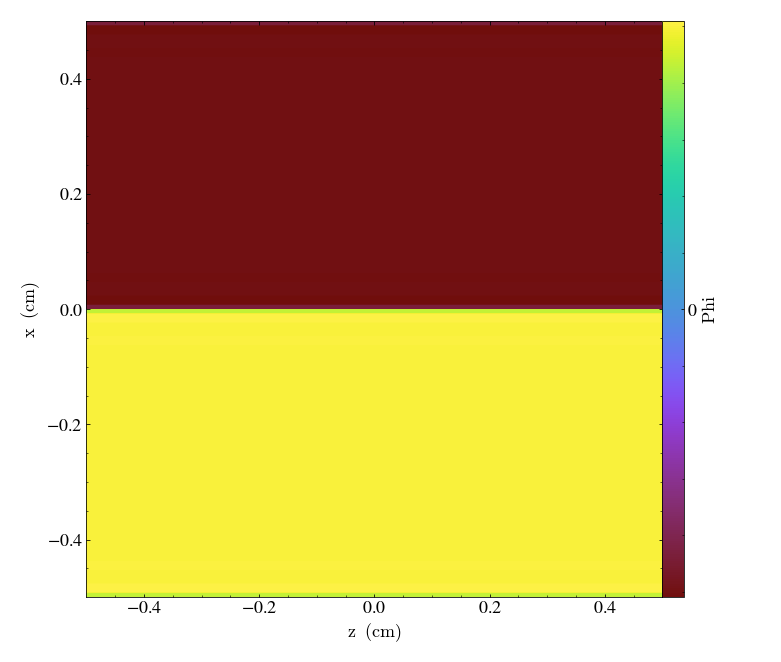

In [52]:
row = df_fluct_flat.iloc[0]

ts = yt.load(row['Directory'] + '/plt*')
# ts = yt.load(directories_fluct[0] + '/plt*')
ds = ts[-1]
slc = yt.SlicePlot(ds, "y", ("boxlib", "phi"))
# slc.save()
# yt_ani(ts, axis = "z")
slc

In [59]:
test = np.zeros((10, 10))

            
test[0:5, :] = 0.5
test[5:, :] = -0.5
test

array([[ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5]])

In [179]:
l = 2
A = 0.5
L = 64

x = np.linspace(0, L-1, L)
x_correct = x/(L-1) *2*np.pi
# x = np.linspace(0, 2*np.pi, L)
x_correct
y = A*np.sin(l*x_correct)

k_to_l_space = L/(2*np.pi)

y = y*L/2 + L/2

# fig, axs = plt.subplots(1, 1)

# axs.plot(x.astype(int), y.astype(int), label = 'Integer')
# axs.plot(x, y, label = 'Float')
# axs.set(xlim = (0, L), ylim = (0, L))
# axs.legend()

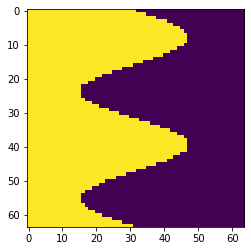

In [180]:
x_int = x.astype(int)
y_int = y.astype(int)

test = np.zeros((L, L))

for i in range(L):
    y_curr = y_int[i]
    test[i, 0:y_curr] = 0.5
    test[i, y_curr:] = -0.5

plt.imshow(test)

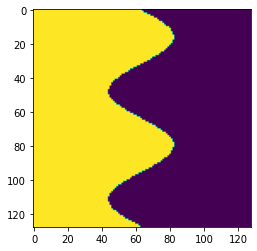

In [267]:
w = 2
A = 0.3
L = 128

test = np.zeros((L, L))

for i in range(L):
    result = A*np.sin(w*(i/(L-1)*2*np.pi))
    # print()
    index = result*L/2 + L/2
    # index = int(result*L/2)
    # print(index - L/2)
    for j in range(L):
        if j - index < 0:
            test[i, j] = 0.5
        else:
            test[i, j] = -0.5
        # if j < index:
        #     test[i, j] = 0.5
        # else:
        #     test[i, j] = -0.5

plt.imshow(test)

In [274]:
from pyevtk.hl import imageToVTK

w = 2
A = 0.2
L = 128

test = np.zeros((L, L, L))

for x in range(L):
    for y in range(L):
        for z in range(L):
            
            rx = x - L//2
            result = A*np.sin(w*(x/(L-1)*2*np.pi))*L/2 + L/2
            ry = y - result
            
            if ry < 0:
                phi = 0.5
            else:
                phi = -0.5
                    
            test[x, y, z] = phi

# plt.imshow(test[:, :, l//2])

imageToVTK("./test_capillary", pointData = {"phi" : test})

'/home/nikhil/Documents/LBMeX/amrex-tutorials/GuidedTutorials/LBM/binary/test_capillary.vti'

In [280]:
unique, counts = np.unique(test, return_counts = True)
unique, counts

sum(counts), counts[0]/sum(counts)

(2097152, 0.49615478515625)

In [183]:
# write = False

# row = df_fluct_flat.iloc[0]

# ts = yt.load(row['Directory'] + '/plt*')

# ani = yt_ani(ts, axis = 'x')

# if write == True:
#     writergif = animation.PillowWriter(fps=5) 
#     ani.save(analysis_dir + '/k_{}-T_{}-R_{}.gif'.format(row['k'], row['T'], row['R']), writer=writergif)
# HTML(ani.to_jshtml())

In [29]:
# #binary_droplet/plt?????



# ts = yt.load('plt?????')
# ds = ts[-1]
# p1 = yt.SlicePlot(ds, 0, ('boxlib','phi'))

# ts = yt.load('plt?????')
# ds = ts[-1]
# p2 = yt.SlicePlot(ds, 0, ('boxlib','phi'))

# from mpl_toolkits.axes_grid1 import AxesGrid

# fig = plt.figure()

# # See http://matplotlib.org/mpl_toolkits/axes_grid/api/axes_grid_api.html
# # These choices of keyword arguments produce a four panel plot that includes
# # four narrow colorbars, one for each plot.  Axes labels are only drawn on the
# # bottom left hand plot to avoid repeating information and make the plot less
# # cluttered.
# grid = AxesGrid(
#     fig,
#     (0.075, 0.075, 0.85, 0.85),
#     nrows_ncols=(1, 2),
#     axes_pad=1.0,
#     label_mode="1",
#     share_all=True,
#     cbar_location="right",
#     cbar_mode="each",
#     cbar_size="3%",
#     cbar_pad="0%",
# )

# for i, p in enumerate([p1,p2]):
#     pl = p.plots[('boxlib','phi')]
#     pl.figure = fig
#     pl.axes = grid[i].axes
#     pl.cax = grid.cbar_axes[i]
#     p._setup_plots()

# #plt.savefig("binary.png")
# plt.show()